# Retrieving texts and counting words

In this example, we'll retrieve the texts of speeches from a remote server and do a basic word count.

## Scenario

Let's say we want to know how many words Achilles speaks to each of his interlocutors. We can search the DICES database for the relevant speeches using the API. Then, to count the number of words, we'll have to retrieve the text of the speeches themselves. Since the DICES *Speech* objects include CTS URNS, we can request the passages from a remote server. 

## Preliminaries

### Install the client library

If you don't have the DICES client library, you can install it with **pip**:
```
pip install git+https://github.com/cwf2/dices-client.git
```

### The DICES API

First step is to instantiate a connection to the DICES api. Two optional arguments allow you to specify endpoints for the DICES database and the CTS server hosting the texts:

- `dices_api`: URL for the DICES API. The official server lives at `http://csa20211203-005.uni-rostock.de/api/`. If you want to run your own server locally, you can download the [DICES backend](https://github.com/cwf2/dices) from GitHub.
- `cts_api`: URL for the CTS server. Default is `https://scaife-cts.perseus.org/api/cts/`, which provides CTS access to (**I think**) the same Perseus texts as the [Scaife Viewer](https://scaife.perseus.org/).

Two other optional params affect the behaviour of the client:
- `progress_class` allows you to pass a class that will be used to create progress bars. For Jupyter notebooks you can use `dicesapi.jupyter.NotebookPBar`.
- `logfile` lets you set a local logfile. This keeps messages out of your notebook.

To create the API instance with default servers:

In [1]:
from dicesapi import DicesAPI
from dicesapi.jupyter import NotebookPBar
api = DicesAPI(
    dices_api='http://localhost:8000/api/',
    progress_class=NotebookPBar,
    logfile='dices.log')

### Matplotlib for figures

Let's also import **pyplot**, for drawing a simple bar graph of the results. Note the Jupyter magic `%matplotlib inline` to display the figure right in the notebook. Some people like `%matplotlib notebook` better — it gives you some fancier display options.

In [2]:
from matplotlib import pyplot
%matplotlib inline

## Running the experiment

Here’s the code for calculating Achilles’ speech lengths by addressee.

### First, download the speeches

Using the API, we can search speeches using a set of key-value pairs [listed in greater detail here](https://cwf2.github.io/dices/2021/06/20/alpha.html). For now, JSON results from the API are paged, so if your search has a lot of results, you may have to wait for several pages to download.

In [5]:
speeches = api.getSpeeches(spkr_name='Achilles', work_title='Iliad', progress=True)

### Count the words for each speech

This involves retrieving each passage from the CTS server, and extracting the plaintext of its contents. In this toy example, we split into words using Python's built-in `split()`, which just looks for whitespace. For more context-aware tokenization, use CLTK.

<div class="alert alert-warning" style="margin:1em 2em">
    <p>Behind the scenes, the <code>getCTS()</code> method shown here is calling <strong>MyCapytain</strong>'s <a href="https://mycapytain.readthedocs.io/en/latest/MyCapytain.classes.html?highlight=gettextualnode#MyCapytain.resolvers.prototypes.Resolver.getTextualNode"><code>getTextualNode()</code></a>, which returns a <a href="https://mycapytain.readthedocs.io/en/latest/MyCapytain.api.html#MyCapytain.resources.texts.local.capitains.cts.CapitainsCtsPassage">CapitainsCtsPassage</a> instance.</p>
</div>

In [6]:
# initialize our counter
count = {}

pbar = NotebookPBar(max=len(speeches))

# iterate over all speeches
for speech in speeches:
    
    # retrieve the passage from the remote library
    cts_passage = speech.getCTS()
    
    if cts_passage is None:
        print(f'Failed to download {speech.urn}')
        
    else:    
        # extract the text and split into words
        plaintext = cts_passage.text
        n_words = len(plaintext.split())

        # tally the word counts for each addressee
        for addressee in speech.addr:
            name = addressee.name
            if name == 'Achilles':
                name = 'himself'
            count[name] = count.get(name, 0) + n_words
        
    pbar.update()

### Examine the results

🤔 Let's see whether it worked!

In [7]:
for name in sorted(count):
    print(name, count[name])

Aeneas 161
Agamemnon 1206
Aias (son of Oileus) 47
Aias (son of Telamon) 115
Antilochus 47
Apollo 48
Asteropaeus 125
Athena 51
Calchas 49
Eurybates 84
Greeks 426
Hector 280
Idomeneus 47
Iphition 26
Iris 71
Lycaon 297
Myrmidons 110
Nestor 45
Odysseus 939
Patroclus 1087
Phoinix 122
Priam 596
Scamander 30
Spercheius 62
Talthybius 84
Thetis 772
Zeus 239
himself 319
horses 61
leaders of the Greeks (Greek soldiers) 199


### Make a simple graph with pyplot

Seems good. Let's visualize it with a simple bar chart.

Text(0.5, 1.0, "Length of Achilles' speeches")

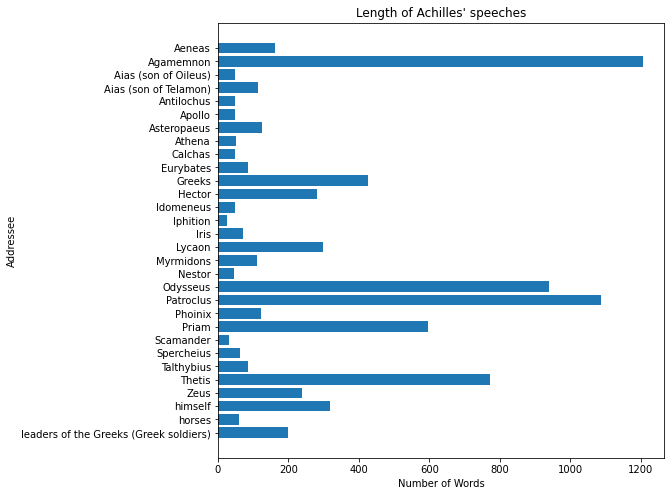

In [8]:
# data for the graph
names = sorted(count)
y_pos = range(len(names))
bars = [count[name] for name in names]

# create a new figure
fig, ax = pyplot.subplots(figsize=(8, 8))

# draw the bars
ax.barh(y_pos, bars, align='center')

# annotate the graph
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Words')
ax.set_ylabel('Addressee')
ax.set_title('Length of Achilles\' speeches')